* https://arxiv.org/pdf/1410.6551.pdf
* https://arxiv.org/pdf/1109.4561.pdf

In [253]:
Nx=8; Ny=10; N=Nx*Ny
p=1; q=Ny
cut_off=Nx
PN=[0,1,2,3]
U=2;

In [255]:
imp_site_1 = 66
imp_site_2 = 15
V_1 = V_2 = 4;

In [256]:
pn = maximum(PN) # filtered particle number
if V_2 != 0
    N_d = 2 # delocalised quasihole number
else
    N_d = 1
end
if N_d == 2
    D = N_d; # two quasihole pinned
else 
    D = Int( ( factorial(N_d + pn - 1) / ( factorial(N_d) * factorial(pn - 1) ) ) * ( (Nx - N_d) / pn)  ) # gorund state degeneracy
end
D

2

In [257]:
using NBInclude
using LinearAlgebra
@nbinclude("Hofstadter First Band Approximation.ipynb"; regex=r"#.*executeme");

In [258]:
reverse(square_lattice(Nx,Ny)[1], dims=1)

10×8 OffsetArray(::Matrix{Int64}, 0:9, 0:7) with eltype Int64 with indices 0:9×0:7:
 73  74  75  76  77  78  79  80
 65  66  67  68  69  70  71  72
 57  58  59  60  61  62  63  64
 49  50  51  52  53  54  55  56
 41  42  43  44  45  46  47  48
 33  34  35  36  37  38  39  40
 25  26  27  28  29  30  31  32
 17  18  19  20  21  22  23  24
  9  10  11  12  13  14  15  16
  1   2   3   4   5   6   7   8

In [259]:
HHH = (H+H')/2
E, U = eigen(dense(HHH).data)
E

165-element Vector{Float64}:
 -10.259866261864005
 -10.259834167578802
 -10.228399958753199
 -10.227640900952823
 -10.224609707282639
 -10.218460735340507
 -10.215090821247331
 -10.210972306881114
 -10.19458818393322
 -10.192826902394474
 -10.189698674495999
 -10.187771167508293
 -10.182862772528091
   ⋮
  -6.041226222306654
  -5.940304271852951
  -5.92593697277925
  -3.420053484619093
  -3.4200394168832937
  -3.420015300472141
  -3.420015300472137
  -3.419996324608739
  -3.419982797424285
  -3.037129595703293
  -3.0031363402143905
   0.0

# Gram-Schmidt Process

In [260]:
function gram_schmidt_process(A; normalize=false)
	# performs Gram Schmidt process on columns of matrix A
	# the columns of the returned matrix Q are the outputs of this process
	
    m = size(A, 1)
	n = size(A, 2)
    Q = zeros(Complex{Float64},m, n)
    
    for j=1:n
        v = A[1:m, j]
		x = A[1:m, j]
        for i = 1:j - 1
            u = Q[1:m, i]
            x -= dot(u, v) * u / dot(u, u)
        end
        Q[1:m, j] = normalize ? x / norm(x) : x
    end

    return Q
end

gram_schmidt_process (generic function with 1 method)

In [261]:
function classical_gram_schmidt_alt(matrix)
    # orthogonalises the columns of the input matrix
    num_vectors = size(matrix)[2]
    orth_matrix = zeros(Complex{Float64},size(matrix))
    for vec_idx = 1:num_vectors
        orth_matrix[:, vec_idx] = matrix[:, vec_idx]
        sum = zeros(size(orth_matrix[:, 1]))
        for span_base_idx = 1:(vec_idx-1)
            # compute sum
            sum += dot(orth_matrix[:, span_base_idx], orth_matrix[:, vec_idx])*orth_matrix[:, span_base_idx]
        end
        orth_matrix[:, vec_idx] -= sum
        # normalise vector
        orth_matrix[:, vec_idx] = orth_matrix[:, vec_idx]/norm(orth_matrix[:, vec_idx])
    end
    return orth_matrix
end

classical_gram_schmidt_alt (generic function with 1 method)

In [262]:
function modified_gram_schmidt(matrix)
    # orthogonalises the columns of the input matrix
    matrix = convert(Matrix{Complex{Float64}}, matrix)
    num_vectors = size(matrix)[2]
    orth_matrix = copy(matrix)
    for vec_idx = 1:num_vectors
        orth_matrix[:, vec_idx] = orth_matrix[:, vec_idx] / norm(orth_matrix[:, vec_idx])
        for span_base_idx = (vec_idx+1):num_vectors
            # perform block step
            orth_matrix[:, span_base_idx] -= dot(orth_matrix[:, span_base_idx], orth_matrix[:, vec_idx])*orth_matrix[:, vec_idx]
        end
    end
    return orth_matrix
end

modified_gram_schmidt (generic function with 1 method)

In [263]:
M = [3+2im 2+0im; 7+5im 1+1im]
GS_1 = gram_schmidt_process(M; normalize=true)
GS_2 = classical_gram_schmidt_alt(M)
GS_3 = modified_gram_schmidt(M)

2×2 Matrix{ComplexF64}:
 0.321634+0.214423im  0.917387-0.310728im
 0.750479+0.536056im  -0.21455-0.125771im

In [264]:
println(GS_1[:,1]'*GS_1[:,2],"\n",GS_2[:,1]'*GS_2[:,2],"\n",GS_3[:,1]'*GS_3[:,2])

-4.163336342344337e-17 + 1.3877787807814457e-17im
7.632783294297951e-17 - 4.163336342344337e-17im
0.0 - 0.27602622373694147im


# Adiabatic 

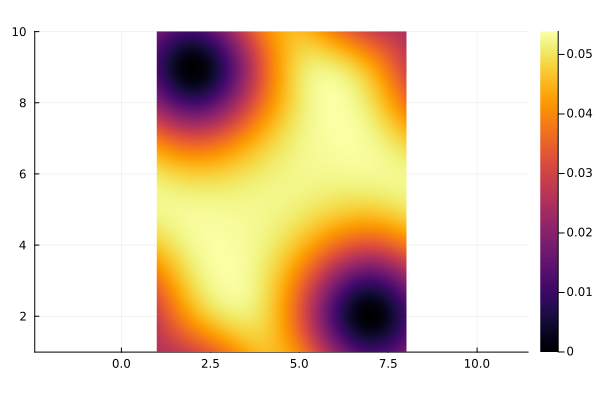

In [265]:
using Plots
using Interpolations

function Interp2D(data, factor)
    IC = CubicSplineInterpolation((axes(data,1), axes(data,2)), data)
    finerx = LinRange(firstindex(data,1), lastindex(data,1), size(data,1) * factor)
    finery = LinRange(firstindex(data,2), lastindex(data,2), size(data,2) * factor)
    nx = length(finerx)
    ny = length(finery)
    data_interp = Array{Float64}(undef,nx,ny)
    for i ∈ 1:nx, j ∈ 1:ny
        data_interp[i,j] = IC(finerx[i],finery[j])
    end
    return finery, finerx, data_interp
end

data = avg_density|>transpose
factor = 50

Plots.heatmap(Interp2D(data, factor), aspect_ratio=:equal)

$
H(t=0)\psi(0)=E(0)\psi(0)
$

In [266]:
# initial_case
H_initial, H_inital_interacting = get_total_H(V_1, V_2, imp_site_1, imp_site_2, num_mb_list_op, H_Kin, H_Int)
E_initial, U_inital = eigen(dense((H_initial+H_initial')/2).data);

In [305]:
# adiabatic process
mobile_imp_sites_1_1 = [66,67,68,69,70,71] #1.
mobile_imp_sites_2_1 = [15,14,13,12,11,10] #2.
mobile_imp_sites_1_2 = [63,55,47,39,31,23,15] #3.
mobile_imp_sites_2_2 = [18,26,34,42,50,58,66] #4.
adiabatic_V_imp = collect(range(start = V_1, length=4, stop=0))
adiabatic_V_imp_reverse = reverse(adiabatic_V_imp)

4-element Vector{Float64}:
 0.0
 1.3333333333333333
 2.6666666666666665
 4.0

In [310]:
function orthogonality()
    
    # Her seferinde ikişerli komşulukları (site1 ve site2) belirle
    for i in 1:length(mobile_imp_sites_1_1)-1
        for (site1,site2) in zip(mobile_imp_sites_1_1[i], mobile_imp_sites_1_1[i+1])
            
            println("SITE 1: ",site1," SITE 2: ",site2, "\n -------------")
            
            vec_set = []
            final_orth_vec_set = []
            
            # Komşu sitelerdeki imp. potansiyellerin adyabatik değişimi
            for (V1, V2) in zip(adiabatic_V_imp, adiabatic_V_imp_reverse)
                
                println("V_1:",V1,"\t","V_2:",V2)

                # Komşuluklarda ki her imp. değişiminde öz-vektörleri hesapla
                H, HH_Int = get_total_H(V1, V2, site1, site2, num_mb_list_op, H_Kin, H_Int)
                E, U = eigen(dense(H).data)
                println("E and U are Calculated!")

                # Hesaplanan öz-vektörlerin dejenereleri seç ve her adımda bir setde topla 
                vec_set = push!(vec_set, U[:,1:2]) # Ground degeneracy is 2
                
                if lastindex(vec_set) != 1
                    t = vec_set[lastindex(vec_set)-1] # t anında (sondan bir önceki) vektörler
                    t_dt = vec_set[lastindex(vec_set)] # t+dt anında (sonda ki) vektörler
                    println("t: ",lastindex(vec_set)-1," t_dt: ",lastindex(vec_set))
                
                    # GRAM-SCHMIDT (D=2 iken)
                    matrix_1 = cat(t,t_dt[:,1],dims=2)
                    orth_t_dt_1 = classical_gram_schmidt_alt(matrix_1)[:,3] # t anında ki her ikisine de dik bir t_dt vektörü
                    
                    matrix_2 = cat(t,t_dt[:,2],dims=2)
                    orth_t_dt_2 = classical_gram_schmidt_alt(matrix_2)[:,3] # t anında ki her ikisine de dik bir diğer t_dt vektörü
                    
                    final_orth_vec_set = cat(orth_t_dt_1, orth_t_dt_2, dims=2) #t_dt anında, t anına dik vektörler seti
                    println("GS Method Completed! \n")
                end
            end
            
        end
    end
    
    return vec_set, final_orth_vec_set
end

orthogonality (generic function with 2 methods)

In [311]:
vec_set, final_orth_vec_set = orthogonality()
final_orth_vec_set
vec_set

SITE 1: 66 SITE 2: 67
 -------------
V_1:4.0	V_2:0.0
E and U are Calculated!
V_1:2.6666666666666665	V_2:1.3333333333333333
E and U are Calculated!
t: 1 t_dt: 2
GS Method Completed! 

V_1:1.3333333333333333	V_2:2.6666666666666665
E and U are Calculated!
t: 2 t_dt: 3
GS Method Completed! 

V_1:0.0	V_2:4.0
E and U are Calculated!
t: 3 t_dt: 4
GS Method Completed! 

SITE 1: 67 SITE 2: 68
 -------------
V_1:4.0	V_2:0.0
E and U are Calculated!
V_1:2.6666666666666665	V_2:1.3333333333333333
E and U are Calculated!
t: 1 t_dt: 2
GS Method Completed! 

V_1:1.3333333333333333	V_2:2.6666666666666665
E and U are Calculated!
t: 2 t_dt: 3
GS Method Completed! 

V_1:0.0	V_2:4.0
E and U are Calculated!
t: 3 t_dt: 4
GS Method Completed! 

SITE 1: 68 SITE 2: 69
 -------------
V_1:4.0	V_2:0.0
E and U are Calculated!
V_1:2.6666666666666665	V_2:1.3333333333333333
E and U are Calculated!
t: 1 t_dt: 2
GS Method Completed! 

V_1:1.3333333333333333	V_2:2.6666666666666665
E and U are Calculated!
t: 2 t_dt: 3
GS M

10-element Vector{Any}:
 ComplexF64[0.0 + 0.0im -0.0 + 0.0im; 1.610827689690504e-17 + 7.425139232918098e-17im 4.4508302423846855e-18 + 1.999867140123279e-18im; … ; -0.018360188576956617 - 0.027049622258199773im -0.0030081593561921195 - 0.0007089114105656015im; 0.0015744683173127092 - 0.0003671865796271582im 0.00018460281617884634 - 0.0018184061789386344im]
 ComplexF64[0.0 + 0.0im 0.0 - 0.0im; -6.278479967421537e-17 - 1.1633256778757009e-16im -1.788670970962608e-17 - 1.752992226130712e-17im; … ; 0.02191846941165518 - 0.01534230581787768im -0.005325171993301454 - 0.0023295545047768654im; 0.0039042218514586374 + 0.004047269560141141im 0.00015617637815881405 + 0.0007824389553300266im]
 ComplexF64[0.0 + 0.0im 0.0 - 0.0im; -6.278479967421537e-17 - 1.1633256778757009e-16im -1.788670970962608e-17 - 1.752992226130712e-17im; … ; 0.02191846941165518 - 0.01534230581787768im -0.005325171993301454 - 0.0023295545047768654im; 0.0039042218514586374 + 0.004047269560141141im 0.00015617637815881405 + 0.00

In [285]:
vec_set[5]

165×2 Matrix{ComplexF64}:
         -0.0+0.0im                   0.0+0.0im
   6.6339e-17+7.52676e-17im  -9.64895e-18+6.57106e-18im
   7.9435e-18-1.38285e-16im  -2.53104e-17+2.48342e-17im
  1.19196e-17+5.03309e-17im   2.72931e-17-2.92496e-18im
   9.5883e-17+5.25167e-17im   9.04227e-17+1.78449e-17im
 -1.90326e-17-2.62299e-16im   7.03671e-17-5.54073e-17im
 -2.75609e-16-3.39385e-17im   5.60106e-17-1.99363e-17im
  8.36091e-17-5.84208e-18im   3.48677e-18-3.19934e-18im
  1.63285e-16-3.01454e-17im  -2.59547e-17-3.68285e-17im
  2.69879e-16-1.71838e-16im  -2.19427e-16+7.10617e-18im
  2.91795e-16+3.10825e-18im   5.01026e-17-5.60221e-17im
  7.92294e-17+5.55396e-17im   -4.2691e-17-1.32843e-16im
  1.18381e-15+2.56574e-16im  -1.70249e-16+3.86583e-16im
             ⋮               
   0.00914374+0.00207434im     0.00718814+0.00023802im
   7.02704e-5-0.00256091im    -0.00262106-0.0066324im
    0.0177293+0.028562im         0.016075+0.0220373im
    0.0108838-0.0179361im       0.0038282-0.00689332im
   -0.

In [276]:
# TEST
println(lastindex(vec_set),"\n")
println(final_orth_vec_set[:,1]'*vec_set[lastindex(vec_set)-1][:,1],"\n",
final_orth_vec_set[:,1]'*vec_set[lastindex(vec_set)-1][:,2],"\n",
final_orth_vec_set[:,2]'*vec_set[lastindex(vec_set)-1][:,1],"\n",
final_orth_vec_set[:,2]'*vec_set[lastindex(vec_set)-1][:,2])

5

1.214306433183765e-17 + 0.0im
0.0 + 1.1102230246251565e-16im
-3.5735303605122226e-16 + 3.3176586478056436e-17im
-4.2934406030425976e-17 + 4.163336342344337e-17im


In [277]:
U_inital[:,1:2]

165×2 Matrix{ComplexF64}:
         0.0-0.0im                  0.0-0.0im
         0.0-0.0im                  0.0-0.0im
         0.0-0.0im                  0.0-0.0im
         0.0-0.0im                  0.0-0.0im
         0.0-0.0im                  0.0-0.0im
         0.0-0.0im                  0.0-0.0im
         0.0-0.0im                  0.0-0.0im
         0.0-0.0im                  0.0-0.0im
         0.0-0.0im                  0.0-0.0im
         0.0-0.0im                  0.0-0.0im
         0.0-0.0im                  0.0-0.0im
         0.0-0.0im                  0.0-0.0im
         0.0-0.0im                  0.0-0.0im
            ⋮               
   0.0184847-0.013519im       0.0106239-0.0025215im
 -0.00129949+0.0011011im     0.00256097-0.00191017im
 -0.00197894+0.0251335im      0.0258191+0.0344705im
 -0.00795775-0.00184203im   -5.76361e-5+0.0139363im
   0.0723174+0.120511im       0.0351638+0.147732im
    0.010675-0.00894823im   -0.00284431-0.000702726im
  -0.0275391+0.000268849im    0.0

In [126]:
U[:,1:2]

165×2 Matrix{ComplexF64}:
         -0.0+0.0im                   0.0-0.0im
 -2.60692e-17+4.98815e-17im   5.12077e-17+2.57269e-17im
  1.10937e-16-3.015e-16im    -3.12365e-17+8.15513e-17im
  7.13507e-17+1.01821e-16im   7.70597e-17+5.37876e-17im
  2.86459e-16+4.99735e-16im  -5.78851e-17+7.07885e-17im
  1.01344e-16+3.336e-16im     4.80968e-17+2.84771e-18im
 -1.08274e-15+3.01245e-16im  -1.48389e-16+1.54044e-16im
 -1.45952e-18+4.66638e-16im   4.29426e-17+5.86717e-17im
  1.52293e-17-1.9448e-16im   -4.89043e-18-1.47069e-16im
 -6.25237e-17+7.56039e-17im   2.56944e-16-5.98783e-17im
  1.70795e-16-5.81056e-16im  -3.66727e-16+1.05988e-15im
  6.36384e-16+1.61671e-16im  -1.66301e-15+6.39062e-17im
  6.43788e-16+5.24211e-16im  -1.58197e-16-2.89846e-16im
             ⋮               
    0.0354643+0.0151894im      -0.0278654+0.0107782im
  -0.00267077+0.020876im       0.00611174+0.00643745im
  -0.00263182+0.0324929im       0.0150537+0.00365379im
   -0.0028384-0.00545249im     -0.0201691-0.000653137im
   0

In [127]:
U_inital[:,1]'*U[:,2]

0.07225081195612147 + 0.12514297438534613im

In [156]:
orth_vec_set = []
orth_vec_set = cat(U_inital[:,1:2], U[:,1:2], dims=2)

165×4 Matrix{ComplexF64}:
         0.0-0.0im         …           0.0-0.0im
         0.0-0.0im            -2.04629e-16-1.3306e-17im
         0.0-0.0im            -6.84189e-17+3.44344e-17im
         0.0-0.0im            -2.64628e-16-9.61503e-17im
         0.0-0.0im             6.74318e-17+1.12156e-16im
         0.0-0.0im         …   1.90717e-16-7.17631e-17im
         0.0-0.0im             1.41181e-16-1.62332e-16im
         0.0-0.0im            -2.68484e-17-7.05955e-17im
         0.0-0.0im            -1.74964e-16-8.5268e-17im
         0.0-0.0im              7.0132e-17+3.26774e-17im
         0.0-0.0im         …  -1.14084e-15-2.21888e-16im
         0.0-0.0im             8.24511e-16-1.63992e-16im
         0.0-0.0im             9.02043e-16+9.12351e-17im
            ⋮              ⋱  
 -0.00617607+0.041935im         0.00462813-0.00510442im
  -0.0193865+0.00245535im       -0.0025909-0.000972164im
   -0.030516+0.00406183im  …     0.0112561+0.00346907im
  0.00280573-0.00172145im      -0.00106802+

In [186]:
ort_vec_set = classical_gram_schmidt_alt(vec_set)

165×4 Matrix{ComplexF64}:
         0.0-0.0im         …           0.0+0.0im
         0.0-0.0im             2.82001e-17-2.69323e-17im
         0.0-0.0im            -1.32778e-17+2.16486e-17im
         0.0-0.0im             7.66009e-17-1.17784e-17im
         0.0-0.0im             1.13068e-16+1.40945e-17im
         0.0-0.0im         …  -1.38853e-16+8.90432e-17im
         0.0-0.0im            -5.39032e-18+3.62077e-17im
         0.0-0.0im             8.44692e-17-1.33181e-16im
         0.0-0.0im             6.52678e-17+1.56824e-17im
         0.0-0.0im             1.38823e-17-2.6051e-17im
         0.0-0.0im         …  -1.01909e-16+5.95945e-19im
         0.0-0.0im            -3.27172e-17+8.26401e-18im
         0.0-0.0im            -2.55572e-16+1.05891e-17im
            ⋮              ⋱  
   0.0151057-0.0210881im         0.0210551+0.0375611im
 -0.00490167-0.0107593im       -0.00460685+0.00163592im
    0.085328+0.0678444im   …    -0.0120553+0.00335973im
  0.00948034-0.00247212im        0.0388555+0

In [189]:
ort_vec_set[:,1]'*ort_vec_set[:,4]

4.163336342344337e-17 - 1.0408340855860843e-17im

In [218]:
W = Vector{Matrix{Complex{Float64}}}()
W = []
AA = push!(W, U_inital[:,1:2])
last(AA[1])

0.005389396735869762 - 0.0im

In [ ]:
path_states = []
for imp_site_2 in mobile_imp_sites
    H = get_total_H(V_1, V_2, imp_site_1, imp_site_2, num_mb_list_op, H_Kin, H_Int)
    E, UU = eigen(dense((H+H')/2).data)
    push!(path_states, UU)
end

In [ ]:
# Gaining phase factor through the path
path_states[1] == path_states[length(mobile_imp_sites)]

In [44]:
psi_0 = path_states[1]
psi_2pi = path_states[length(mobile_imp_sites)]
B = zeros(Complex{Float64}, size(H)[1], size(H)[2])
for i in 1:size(H)[1]
    for j in 1:size(H)[2]
        B_ij = psi_2pi[:,j]'*psi_0[:,i]
        B[i,j] = B_ij
    end
end
B_E, B_U = eigen(B)

Eigen{ComplexF64, ComplexF64, Matrix{ComplexF64}, Vector{ComplexF64}}
values:
165-element Vector{ComplexF64}:
 -0.9998988915483269 + 0.014219939536697802im
 -0.9998564432316362 - 0.01694381681311317im
 -0.9996416419933147 + 0.026769153757799334im
 -0.9992930991605464 + 0.03759390868371246im
 -0.9962018384910186 - 0.08707408906835117im
 -0.9930915472466821 + 0.11734214412220785im
 -0.9926511086094018 - 0.12101147291281818im
 -0.9890870103292095 + 0.1473325693729363im
  -0.983107194451102 - 0.18303071933009463im
 -0.9783755858733468 + 0.20683619839619044im
 -0.9776428873111878 + 0.2102721686049774im
 -0.9769735435963287 - 0.21336048160995255im
 -0.9669062869189581 - 0.2551317940136167im
                     ⋮
  0.9814126651002322 - 0.1919093035286761im
  0.9856273728566584 - 0.16893395714204337im
  0.9862308711420685 + 0.16537432934512164im
  0.9909587842083434 + 0.13416664265127926im
  0.9918495310755842 - 0.12741470756996873im
  0.9961969380052079 + 0.08713013662924528im
  0.9970589363